In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from Churn.repos.churn.params_manager import load_params

import optuna

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
from params_manager import INTERNAL_PATH, SUBMIT_PATH

seed = 142

In [4]:
params_xgb = load_params('xbg2')
params_cat = load_params('cat2')

In [5]:
t = pd.read_csv(INTERNAL_PATH / 'train.csv')
t = t[t['outlier'] == 0].drop('outlier', axis=1)

X = t.drop('target', axis=1)
y = t['target']

cat_col = X.select_dtypes(include=['object']).columns.tolist()
X.shape

(63636, 167)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=seed, stratify=y)

X_train_num = X_train.drop(cat_col, axis=1)
X_test_num = X_test.drop(cat_col, axis=1)

In [7]:
predictions = []
score = []

In [8]:
for i in tqdm(params_cat):
    model_cat = CatBoostClassifier(verbose=False, **i)
    model_cat.fit(X_train, y_train)
    pred = model_cat.predict_proba(X_test)[:, 1]
    predictions.append(pred)
    _score = concordance_index(y_test, pred)
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/7 [00:00<?, ?it/s]

0.7865805519614304
----------------------------------------------
0.7863645837842691
----------------------------------------------
0.7839216742584211
----------------------------------------------
0.7852557226756967
----------------------------------------------
0.7841471020662077
----------------------------------------------
0.7869617430090925
----------------------------------------------
0.7856586388072528
----------------------------------------------


In [9]:
for i in tqdm(params_xgb):
    model_xgb = XGBClassifier(**i)
    model_xgb.fit(X_train_num, y_train)
    pred = model_xgb.predict_proba(X_test_num)[:, 1]
    predictions.append(pred)
    _score = concordance_index(y_test, pred)
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/7 [00:00<?, ?it/s]

0.7894705893670545
----------------------------------------------
0.7891302029972599
----------------------------------------------
0.7884789314786044
----------------------------------------------
0.7878628129093495
----------------------------------------------
0.7873276623649397
----------------------------------------------
0.7867878220883978
----------------------------------------------
0.786735353204971
----------------------------------------------


In [10]:
score

[0.7865805519614304,
 0.7863645837842691,
 0.7839216742584211,
 0.7852557226756967,
 0.7841471020662077,
 0.7869617430090925,
 0.7856586388072528,
 0.7894705893670545,
 0.7891302029972599,
 0.7884789314786044,
 0.7878628129093495,
 0.7873276623649397,
 0.7867878220883978,
 0.786735353204971]

## Creating an ensemble

In [11]:
from itertools import chain, combinations
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(2, len(ss)+1)))

CIs = []
for subset in all_subsets(range(len(predictions))):
    preds = list(map(predictions.__getitem__, subset))
    ensemble_predictions = np.average(preds, axis=0)
    CIs.append((subset, concordance_index(y_test,  ensemble_predictions)))

CIs = sorted(CIs, key=lambda x: x[1], reverse=True)
len(CIs)

8178

In [12]:
CIs[:30]

[((1, 7, 8), 0.7902531333022288),
 ((1, 3, 7, 8), 0.7902290833938589),
 ((5, 7, 8), 0.7902126492898062),
 ((1, 5, 7, 8), 0.7902030293264583),
 ((1, 4, 7, 8), 0.7901784182535598),
 ((0, 1, 7, 8), 0.7901676759611546),
 ((3, 5, 7, 8), 0.7901592584932251),
 ((1, 3, 4, 7, 8), 0.7901446682154808),
 ((1, 3, 5, 7, 8), 0.7901425037237275),
 ((0, 1, 3, 7, 8), 0.7901259092869523),
 ((0, 7, 8), 0.790124065460644),
 ((1, 5, 7, 8, 10), 0.790111319009208),
 ((4, 5, 7, 8), 0.7901102768465119),
 ((0, 1, 7, 8, 10), 0.7901081123547586),
 ((1, 7, 8, 10), 0.790105466864838),
 ((1, 3, 7, 8, 10), 0.7900997750531904),
 ((0, 5, 7, 8), 0.7900972898959921),
 ((1, 4, 5, 7, 8), 0.7900869484353932),
 ((1, 5, 7, 8, 11), 0.7900831004500539),
 ((0, 1, 4, 7, 8), 0.7900827797846091),
 ((1, 5, 7, 8, 9), 0.7900778896365738),
 ((1, 6, 7, 8), 0.7900750838139307),
 ((0, 3, 7, 8), 0.7900709953295078),
 ((1, 4, 7, 8, 10), 0.7900697126677281),
 ((1, 7, 10), 0.7900633795251907),
 ((0, 1, 7, 8, 11), 0.7900612951997986),
 ((0, 1, 

In [13]:
nc = np.array(list(map(lambda x: x[1], CIs)))
len(nc[nc > 0.79])

array([0.79025313, 0.79022908, 0.79021265, 0.79020303, 0.79017842,
       0.79016768, 0.79015926, 0.79014467, 0.7901425 , 0.79012591,
       0.79012407, 0.79011132, 0.79011028, 0.79010811, 0.79010547,
       0.79009978, 0.79009729, 0.79008695, 0.7900831 , 0.79008278,
       0.79007789, 0.79007508, 0.790071  , 0.79006971, 0.79006338,
       0.7900613 , 0.79005761, 0.79005504, 0.79005504, 0.79005264,
       0.79005168, 0.79005127, 0.79004967, 0.79004887, 0.79004887,
       0.7900451 , 0.7900443 , 0.79004302, 0.79003853, 0.79003845,
       0.7900338 , 0.79003244, 0.79003195, 0.79003107, 0.79003043,
       0.79002322, 0.79002225, 0.79001841, 0.7900176 , 0.79001608,
       0.79001456, 0.79001416, 0.79001328, 0.79001207, 0.79001119,
       0.79001055, 0.79001031, 0.79000887, 0.79000823, 0.79000702,
       0.79000606, 0.79000558, 0.7900055 , 0.79000446, 0.79000157,
       0.79000125])

In [14]:
old_verbosity = optuna.logging.get_verbosity()
optuna.logging.set_verbosity(optuna.logging.WARNING)

best_CI = 0
best_subset = None
best_subsets = []
for (subset, CI) in CIs[:len(nc)]:
    preds = list(map(predictions.__getitem__, subset))
    def objective(trial):
        weights = []
        for i in range(len(preds)):
            weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
        
        ensemble_predictions = np.average(preds, axis=0, weights=weights)
        return concordance_index(y_test,  ensemble_predictions)

    study = optuna.study.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000)
    if study.best_value > best_CI:
        best_CI = study.best_value
        best_subset = subset
        print(f'Best subset: {subset}')
        print(f'Best CI: {best_CI}')
        best_subsets.append((best_subset, best_CI))

# optuna.logging.set_verbosity(old_verbosity)

Best subset: (1, 7, 8)
Best CI: 0.790290731325647
Best subset: (1, 3, 7, 8)
Best CI: 0.7902912123238144
Best subset: (1, 5, 7, 8)
Best CI: 0.7903387509760255
Best subset: (1, 5, 7, 8, 10)
Best CI: 0.7903418774641136
Best subset: (1, 3, 5, 7, 8, 10)
Best CI: 0.7903421179631972


In [15]:
_predictions6 = [predictions[2], predictions[3], predictions[7],
                predictions[8], predictions[9], predictions[10]]

def objective(trial):
    weights = []
    for i in range(len(_predictions6)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions6, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_2.db"
study_name = "ensemble_6"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [16]:
study.best_value

0.7903438816231444

In [17]:
weights6 = list(best_weights.values())
weights6

[0.6759404119188154,
 7.470884124259245e-06,
 0.39436594395691293,
 0.999313873347907,
 0.5160167974516661,
 0.02109019230165833]

In [18]:
_predictions5 = [predictions[1], predictions[5],
                predictions[7], predictions[8], predictions[10]]
def objective(trial):
    weights = []
    for i in range(len(_predictions5)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions5, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_2.db"
study_name = "ensemble_5"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [19]:
study.best_value

0.7903442824549505

In [20]:
weights5 = list(best_weights.values())
weights5

[0.6748112941377284,
 0.3599765870873497,
 0.9579044883744967,
 0.4981941626762752,
 0.03004972246958215]

In [21]:
_predictions4_1 = [predictions[1], predictions[5],
                predictions[7], predictions[8]]
def objective(trial):
    weights = []
    for i in range(len(_predictions4_1)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions4_1, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_2.db"
study_name = "ensemble_4_1"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [22]:
study.best_value

0.7903413162995849

In [23]:
weights4_1 = list(best_weights.values())
weights4_1

[0.6525270332036371,
 0.3433582010288681,
 0.9129870498114102,
 0.4672548853633455]

In [24]:
_predictions4_2 = [predictions[1], predictions[3],
                predictions[7], predictions[8]]
def objective(trial):
    weights = []
    for i in range(len(_predictions4_2)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions4_2, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_2.db"
study_name = "ensemble_4_2"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [25]:
study.best_value

0.7902934569819289

In [26]:
weights4_2 = list(best_weights.values())
weights4_2

[0.9186569304331755,
 0.0002195348963950211,
 0.7363561486701803,
 0.6177472668778808]

In [27]:
_predictions3 = [predictions[1],
                predictions[7], predictions[8]]
def objective(trial):
    weights = []
    for i in range(len(_predictions3)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions3, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_2.db"
study_name = "ensemble_3"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [28]:
study.best_value

0.7902927354846778

In [29]:
weights3 = list(best_weights.values())
weights3

[0.918823862728365, 0.7353787014813309, 0.6169380911179919]

## ROC

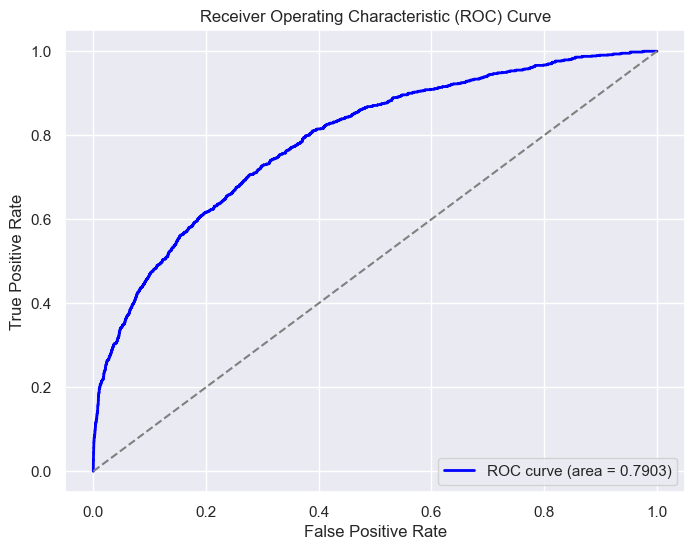

Best Threshold: 0.06478610964014615
Sensitivity (True Positive Rate) at best threshold: 0.7046728971962617
False Positive Rate at best threshold: 0.27586206896551724


In [30]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, np.average(_predictions5, axis=0, weights=weights5))

# Calculate the area under the ROC curve (ROC AUC)
roc_auc = roc_auc_score(y_test, np.average(_predictions5, axis=0, weights=weights5))

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Find the threshold that maximizes sensitivity and minimizes false positives
best_threshold_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

## Youden's J statistic

In [31]:
# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

best_threshold_idx = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

Best Threshold: 0.06478610964014615
Sensitivity (True Positive Rate) at best threshold: 0.7046728971962617
False Positive Rate at best threshold: 0.27586206896551724


In [32]:
X_num = X.drop(cat_col, axis=1)

In [33]:
submit = pd.read_csv(INTERNAL_PATH / 'submit_time.csv')[X.columns]
submit = submit[X.columns]
submit_num = submit.drop(cat_col, axis=1)
submit.shape

(32000, 167)

In [34]:
predictions_submit = []

for i in [params_cat[1], params_cat[5]]:
    model_cat = CatBoostClassifier(verbose=False, **i)
    model_cat.fit(X, y)
    predictions_submit.append(model_cat.predict_proba(submit)[:, 1])

for i in [params_xgb[0], params_xgb[1], params_xgb[3]]:
    model_xgb = XGBClassifier(**i)
    model_xgb.fit(X_num, y)
    predictions_submit.append(model_xgb.predict_proba(submit_num)[:, 1])

len(predictions_submit)

5

In [35]:
submit['predict'] = np.average(predictions_submit, axis=0, weights=weights5)
submit[['user_id', 'predict']].to_csv(SUBMIT_PATH / 'submit_Ensemble_2.csv', index=False)
submit.shape

(32000, 168)